# Temperature Model Test

## Import dependencies and data

In [1]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'

In [3]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3]
)

# convert index.date col to datetime
data.index = data.index.set_levels(
    levels=pd.to_datetime(data.index.get_level_values(3).values),
    level=3
)

In [4]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101_default'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('wind', 'SMHI_direction'),
    ('wind', 'SMHI_speed'),
    ('setpoints', 'DC_GP101_default'),
    ('setpoints', 'TA01_GT10X_GM10X_default')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [5]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

# check for NaNs
nadat = data.droplevel(level=0, axis=1)[[
    'TA01_GP101_default', 
    #'FF01_GP101_default',
    'DC_GP101_default',
    'TA01_GT10X_GM10X_default'
]]

# delete Nan-data
del nadat

Number of NAs

category      sensor_ID               
flow          TA01_GP101_default          0
temperatures  DC_GT401_GM401              0
              TA01_GT10X_GM10X            0
              DC_GT301_damped             0
              DC_GT301_outdoor            0
wind          SMHI_direction              0
              SMHI_speed                  0
setpoints     DC_GP101_default            0
              TA01_GT10X_GM10X_default    0
dtype: int64





## Process / transform variables 

In [6]:
# remove erroneous setpoints data
data[data.setpoints.TA01_GT10X_GM10X_default == 0.0].TA01_GT10X_GM10X_default = 20.0

# Use temperature Diff. w.r.t. setpoint
data[('temperatures', 'TA01_GT10X_GM10X_diff')] = \
    data[('temperatures', 'TA01_GT10X_GM10X')] - data[('setpoints', 'TA01_GT10X_GM10X_default')]

In [8]:
# create variable f. time to account for time-specific effects (e.g. transpiration)

data[('time', 'minutes')] = data.index.get_level_values(3)
data[('time', 'min_sin')] = data.time.minutes.apply(
    lambda d: abs(np.sin((d.hour * 60 + d.minute) * (2 * np.pi / (24 * 60 * 60))))
)
data[('time', 'min_cos')] = data.time.minutes.apply(
    lambda d: abs(np.cos((d.hour * 60 + d.minute) * (2 * np.pi / (24 * 60 * 60))))
)

In [9]:
# create variable f. wind distribution
wv = data.pop(('wind', 'SMHI_speed'))

# Convert to radians.
wd_rad = data.pop(('wind', 'SMHI_direction'))*np.pi / 180

# Calculate the wind x and y components.
data[('wind', 'Wx')] = wv*np.cos(wd_rad)
data[('wind', 'Wy')] = wv*np.sin(wd_rad)

### Plot pairwise correlation matrix

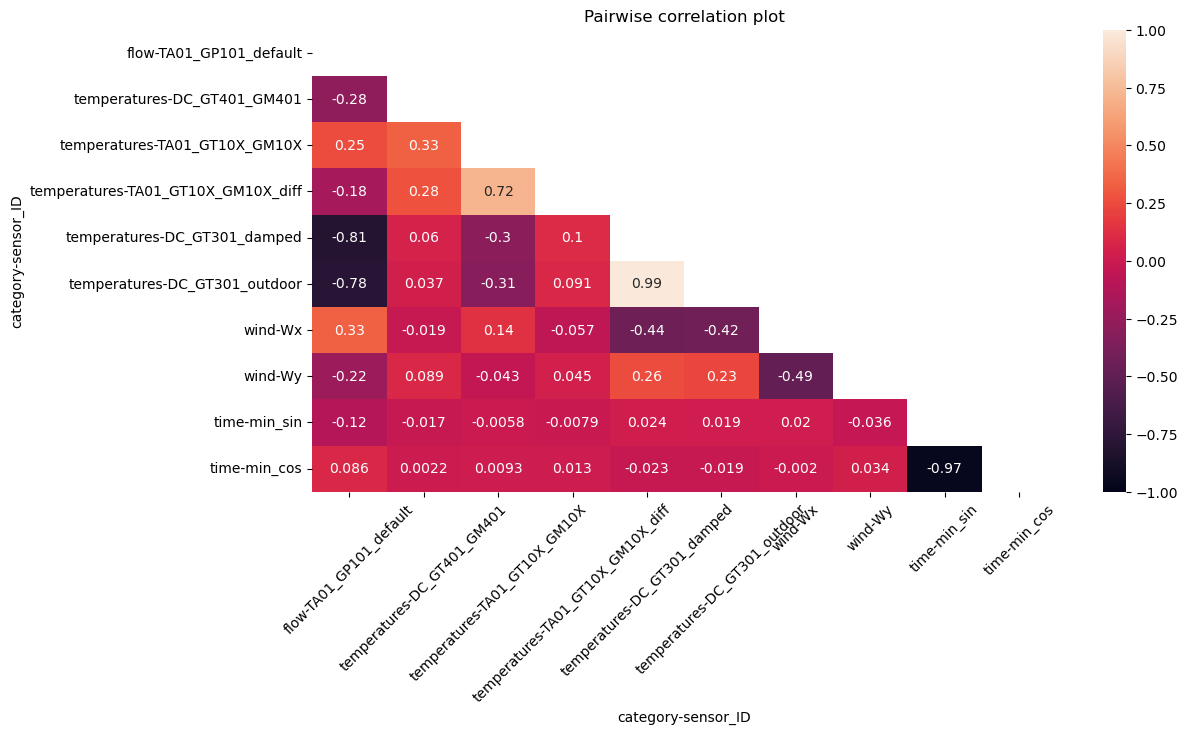

In [15]:
corr = data_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 6))
sns.heatmap(corr, mask=mask, vmin=-1.0, vmax=1.0, annot=True)

plt.xticks(rotation=45)
plt.title('Pairwise correlation plot')
plt.show()

# delete correlation data
del corr

## Preparing data

In [11]:
### SET N_STEPS
n_steps = 60
t_steps = 10

### MASK f. TRAIN/TEST SPLIT
mask = data.index.get_level_values(0) == 2

### GET MODEL VARS
model_vars = [
    ('flow', 'TA01_GP101_default'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'TA01_GT10X_GM10X_diff'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('wind', 'Wx'),
    ('wind', 'Wy'),
    ('time', 'min_sin'),
    ('time', 'min_cos')
]

In [14]:
# get train & test data
data_train = data[~mask][model_vars].copy()
data_test  = data[mask][model_vars].copy()

# delete original dataset & filtering mask
del data, mask

# get mean & std f. whitening
mean = np.mean(
    data_train.values, 
    axis=0
)

std  = np.std(
    data_train.values, 
    axis=0
)

### Erroneous seqeunces

Since we have sequential data and missing/removed days, we will have some outlier series for which there is an "erroneous" break. Since e.g. December $16$ is removed from data, there will be sequences for which data starts December $15$ and continues/end in December $17$, and so on. We want to deal with these cases by removing the first number of sequences in a day corresponding to the number of **n_steps**, for when that day is preceded by a *deleted day*.

In [16]:
def date_flagger(data, n_steps):
    # get flagged dates
    data['day'] = data.index.get_level_values(1).values
    data['date_flag'] = data.day - data.day.shift(periods=n_steps) > 1

    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['day'], data['date_flag']
    
    return flagged_idx

def data_split(data, n_steps, t_steps, mean, std):
    """
    Split and whiten data. Using training mean and s.d. also for test data.
    """
    # get flagged dates, accounting for clipped 
    flags = date_flagger(
        data, 
        n_steps
    )
    
    # get numeric data
    dvals = (data.values - mean) / std
    n = len(data)
    
    # delete dataset
    del data
    
    # get all n_step-sequences from data series
    sequences = np.stack([
        dvals[i:i+n_steps, :] for i in range(n - n_steps)
    ]) 
    
    # get mask f. flags
    mask = [idx not in flags for idx in range(len(sequences))]
    sequences = sequences[mask]
    
    # get targets, delete mask
    targets = dvals[n_steps:][mask]
    del mask
    
    # clip t_steps from sequences and targets
    sequences = sequences[:-t_steps]
    targets = targets[t_steps:]
    
    # return sequences w. channel
    #return sequences[..., np.newaxis]
    return sequences, targets

In [17]:
# get sequences f. training and test data
X_train, Y_train = data_split(data_train, n_steps=n_steps, t_steps=t_steps, mean=mean, std=std)
X_test, Y_test = data_split(data_test, n_steps=n_steps, t_steps=t_steps, mean=mean, std=std)

# filter Y-data
####Y_train = Y_train[mask]
Y_train = Y_train[:, 3]
Y_test = Y_test[:, 3]

# delete data sets
del data_train, data_test

## Define model

In [18]:
layerList = [
    layers.Input(shape=(
        X_train.shape[1],
        X_train.shape[2]
    )),
    layers.Conv1D(
        filters=64,
        kernel_size=7, 
        padding="same", 
        strides=2, 
        activation="relu"
    ),
    layers.Dropout(rate=0.2),
    layers.Conv1D(
        filters=32,
        kernel_size=7, 
        padding="same", 
        strides=2, 
        activation="relu"
    ),
    layers.Dropout(rate=0.2),
    #layers.Flatten(),
    layers.LSTM(
        units=16,
        activation='tanh',
        recurrent_activation='sigmoid'
    ),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation=None)
]

In [19]:
model = tf.keras.models.Sequential(layers=layerList, name='model')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            4544      
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            14368     
                                                                 
 dropout_1 (Dropout)         (None, 15, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 64)                2112  

In [20]:
trainHist = model.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    #callbacks=[
    #    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    #],
)

Epoch 1/20
1401/1401 [==============================] - 32s 21ms/step - loss: 0.3621 - val_loss: 0.2862
Epoch 2/20
1401/1401 [==============================] - 30s 22ms/step - loss: 0.2775 - val_loss: 0.2659
Epoch 3/20
1401/1401 [==============================] - 30s 22ms/step - loss: 0.2524 - val_loss: 0.7889
Epoch 4/20
1401/1401 [==============================] - 32s 23ms/step - loss: 0.2318 - val_loss: 0.5027
Epoch 5/20
1401/1401 [==============================] - 32s 23ms/step - loss: 0.2303 - val_loss: 0.6236
Epoch 6/20
1401/1401 [==============================] - 32s 23ms/step - loss: 0.2234 - val_loss: 0.7531
Epoch 7/20
1401/1401 [==============================] - 33s 23ms/step - loss: 0.2165 - val_loss: 0.6664
Epoch 8/20
1401/1401 [==============================] - 31s 22ms/step - loss: 0.2058 - val_loss: 0.7267
Epoch 9/20
1401/1401 [==============================] - 32s 23ms/step - loss: 0.2025 - val_loss: 0.9295
Epoch 10/20
 789/1401 [===============>..............] - ETA: 12

KeyboardInterrupt: 

In [28]:
preds = model.predict(X_train)

3501/3501 [==============================] - 15s 4ms/step


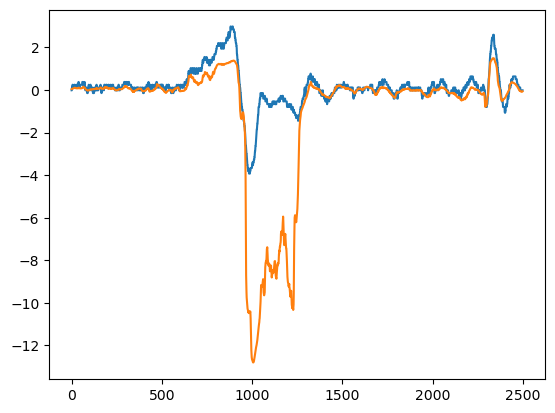

In [32]:
plt.plot(Y_train[-2510:-10])
plt.plot(preds[-2500:])